In [1]:
import numpy as np
from conduction import ConductionND
from conduction.inversion import InvObservation, InvPrior
from conduction import InversionND
from petsc4py import PETSc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
minX, maxX = 0.0, 1000.0
minY, maxY = 0.0, 1000.0
minZ, maxZ = -35e3, 1000.0
nx, ny, nz = 10, 9, 10
n = nx*ny*nz

mesh = ConductionND((minX, minY, minZ), (maxX, maxY, maxZ), (nx,ny,nz))

# BCs
mesh.boundary_condition('maxZ', 298.0, flux=False)
mesh.boundary_condition('minZ', 0.04, flux=True)

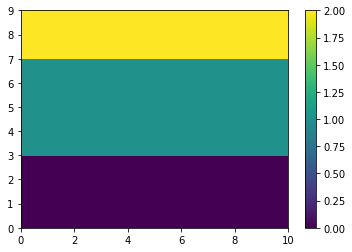

In [3]:
lithology = np.zeros((nz,ny,nx), dtype='int32')
lithology[:,3:7,:] = 1
lithology[:,7:,:]  = 2

lithology_index = np.unique(lithology)

plt.pcolor(lithology[5,:,:])
plt.colorbar()

In [4]:
def hofmeister1999(k0, T, a=0.25, c=0.0):
    return k0*(298.0/T)**a + c*T**3

def hofmeister1999_ad(k0, T, a=0.25, c=0.0):
    dkda = np.log(298.0/T)*k0*(298.0/T)**a
    dkdk0 = (298.0/T)**a
    dkdT = -a*k0/T*(298.0/T)**a
    return dkdk0, dkdT, dkda

def attenuation(Vsyn, P, psi, B):
    Peff = P*0.1 - psi*P*0.1 # MPa
    Q = 2.0*B * np.tan(0.26*np.pi/2) * np.exp(-Peff/12)
    return Q

def attenuation_ad(Vsyn, P, psi, B):
    Peff = P*0.1 - psi*P*0.1 # MPa
    Q = 2.0*B * np.tan(0.26*np.pi/2) * np.exp(-Peff/12)
    dQdpsi = 0.1*P/12 * Q # !
    dQdB = 2.0 * np.tan(0.26*np.pi/2) * np.exp(-Peff/12)
    return dQdpsi, dQdB

In [5]:
def forward_model(self, x, bc='Z'):
    k_list, H_list, a_list, psi_list, B_list = np.array_split(x[:-1], 5)
    q0 = x[-1]
    
    # map to mesh
    k0, H, a, psi, B = self.map(k_list, H_list, a_list, psi_list, B_list)
    k = k0.copy()
    
    self.mesh.update_properties(k0, H)
    self.mesh.boundary_condition("max"+bc, 298.0, flux=False)
    self.mesh.boundary_condition("min"+bc, q0, flux=True)
    rhs = self.mesh.construct_rhs()
    
    error = 10.
    tolerance = 1e-5
    i = 0
    while error > tolerance:
        k_last = k.copy()
        self.mesh.diffusivity[:] = k
        T = self.linear_solve(rhs=rhs) # solve
        k = hofmeister1999(k0, T, a)
        error = np.absolute(k - k_last).max()
        i += 1
    print("{} iterations".format(i))
        
    q = self.heatflux(T, k)
    delT = self.gradient(T)
    rho, Vsp, dVspdT = self.lookup_velocity()
    P = rho*np.abs(self.mesh.coords[:,-1])*9.806*1e-5
    
    # attenuation
    Q = attenuation(Vsp, P, psi, B)
    Vs = Vsp * (1.0 - 0.5*(1.0/np.tan(np.pi*0.26/2.0))*Q)
    self.Vsp = Vsp
    self.Vs = Vs
    self.Q = Q
    
    cost = 0.0
    cost += self.objective_routine(q=q[0], T=T, delT=delT[0], Vs=Vs) # observations
    cost += self.objective_routine(k=k_list, H=H_list, a=a_list, psi=psi_list, B=B_list, q0=q0) # priors
    return cost

In [6]:
def adjoint_model(self, x, bc='Z'):
    k_list, H_list, a_list, psi_list, B_list = np.array_split(x[:-1], 5)
    q0 = x[-1]
    
    # map to mesh
    k0, H, a, psi, B = self.map(k_list, H_list, a_list, psi_list, B_list)
    k = [k0.copy()]
    T = [None]
    
    self.mesh.update_properties(k0, H)
    self.mesh.boundary_condition("max"+bc, 298.0, flux=False)
    self.mesh.boundary_condition("min"+bc, q0, flux=True)
    rhs = self.mesh.construct_rhs()
    
    error = 10.
    tolerance = 1e-5
    i = 0
    self.mesh.temperature._gdata.set(0.)
    while error > tolerance:
        self.mesh.diffusivity[:] = k[i]
        # solve
        Ti = self.linear_solve(rhs=rhs)
        ki = hofmeister1999(k0, Ti, a)
        T.append(Ti.copy())
        k.append(ki.copy())
        error = np.absolute(k[-1] - k[-2]).max()
        i += 1
    print("{} iterations".format(i))

    q = self.heatflux(T[-1], k[-1])
    delT = self.gradient(T[-1])
    rho, Vsp, dVspdT = self.lookup_velocity()
    P = rho*np.abs(self.mesh.coords[:,-1])*9.806*1e-5
    
    # attenuation
    Q = attenuation(Vsp, P, psi, B)
    Vs = Vsp * (1.0 - 0.5*(1.0/np.tan(np.pi*0.26/2.0))*Q)
    
    cost = 0.0
    cost += self.objective_routine(q=q[0], T=T[-1], delT=delT[0], Vs=Vs) # observations
    cost += self.objective_routine(k=k_list, H=H_list, a=a_list, q0=q0) # priors
    
    ## AD ##
    dk = np.zeros_like(H)
    dH = np.zeros_like(H)
    dT = np.zeros_like(H)
    da = np.zeros_like(H)
    dk0 = np.zeros_like(H)
    dq0 = np.array(0.0)
    dpsi = np.zeros_like(H)
    dB = np.zeros_like(H)
    dQ = np.zeros_like(H)
    
    # priors
    dcdk_list = self.objective_routine_ad(k=k_list)
    dcdH_list = self.objective_routine_ad(H=H_list)
    dcda_list = self.objective_routine_ad(a=a_list)
    dcdpsi_list = self.objective_routine_ad(psi=psi_list)
    dcdB_list = self.objective_routine_ad(B=B_list)
    dcdq0 = self.objective_routine_ad(q0=q0)
    # observations
    dT += self.objective_routine_ad(T=T[-1])

    dq = np.zeros_like(q)
    dq[0] = self.objective_routine_ad(q=q[0])
    
    ddelT = np.zeros_like(delT)
    ddelT[0] = self.objective_routine_ad(delT=delT[0])
    
    dVs = self.objective_routine_ad(Vs=Vs)
    dVsdQ = -Vsp*0.5*(1.0/np.tan(np.pi*0.26/2.0))
    dVsdT = dVspdT*(1.0 - 0.5*(1.0/np.tan(np.pi*0.26/2.0))*Q)
    dQdpsi, dQdB = attenuation_ad(Vsp, P, psi, B)
    
    dQ += dVsdQ*dVs
    dT += dVsdT*dVs
    dpsi += dQdpsi*dQ
    dB += dQdB*dQ
    

    dTd = self.gradient_ad(ddelT, T[-1])
    dT += dTd
    
    dTq, dkq = self.heatflux_ad(dq, q, T[-1], k[-1])
    dT += dTq
    dk += dkq
    

    # solve
    for j in xrange(i):
        dkdT, dkdk0, dkda = hofmeister1999_ad(T[-1-j], k0, a)
        
        dk0 += dkdk0*dk
        dT  += dkdT*dk
        da  += dkda*dk
        
        dk.fill(0.0)
        

        self.mesh.diffusivity[:] = k[-1-j]
        dA, db = self.linear_solve_ad(T[-1-j], dT)

        dk += dA
        dH += -db
        dz = self.grid_delta[-1]
        lowerBC_mask = self.mesh.bc["min"+bc]["mask"]
        dq0 += np.sum(-db[lowerBC_mask]/dz/inv.ghost_weights[lowerBC_mask])
        
        dT.fill(0.0)
        
    dk0 += dk
        
    # pack to lists
    dk_list, dH_list, da_list, dpsi_list, dB_list = inv.map_ad(dk0, dH, da, dpsi, dB)
    dk_list += dcdk_list
    dH_list += dcdH_list
    da_list += dcda_list
    dpsi_list += dcdpsi_list
    dB_list += dcdB_list
    dq0 += dcdq0
    
    dx = np.hstack([dk_list, dH_list, da_list, dpsi_list, dB_list, [dq0]])
    
    return cost, dx

Construct Perplex table

In [7]:
from conduction.tools import PerplexTable
PerpleX_dir = "/home/ben/Dropbox/PhD/Perplex/Projects/mq/"

T, P, rho, vs, vs_T = np.loadtxt(PerpleX_dir+'moralana/moralana1.tab', skiprows=13, unpack=True)

vtable = PerplexTable(T,P)
for idx in lithology_index:
    field = np.column_stack([rho, vs, vs_T])
    vtable.add_field(field, idx)

In [8]:
inv = InversionND(lithology.flatten(), mesh)
inv.add_perplex_table(vtable)

k = np.array([3.5, 2.0, 3.2])
H = np.array([0.1e-6, 1e-6, 2e-6])
a = np.array([0.25, 0.25, 0.25])*0.0
psi = np.array([0.999, 0.997, 0.998])
B = np.array([0.38, 0.36, 0.37])
q0 = 35e-3

x = np.hstack([k, H, a, psi, B, [q0]])
dx = x*0.01

# Priors
k_prior = k*1.1
H_prior = H*1.1
a_prior = a*1.1
psi_prior = psi*1.1
B_prior = B*1.1
q0_prior = np.array(30e-3)

sigma_k = k*0.1
sigma_H = H*0.1
sigma_a = a*0.1 + 0.1
sigma_psi = psi*0.1
sigma_B = B*0.1
sigma_q0 = np.array(5e-3)

In [9]:
kp = InvPrior(k_prior, sigma_k)
Hp = InvPrior(H_prior, sigma_H)
ap = InvPrior(a_prior, sigma_a)
psip = InvPrior(psi_prior, sigma_psi)
Bp = InvPrior(B_prior, sigma_B)
q0p = InvPrior(q0_prior, sigma_q0)

inv.add_prior(k=kp, H=Hp, a=ap, psi=psip, B=Bp, q0=q0p)

fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
finite difference -2.1351
adjoint -2.26


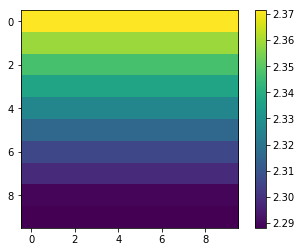

In [10]:
P = np.abs(mesh.coords[:,-1])*9.806*2700.*1e-5
Q = attenuation(inv.Vsp, P, 0.999, 0.38)
Vs = inv.Vsp * (1.0 - 0.5*(1.0/np.tan(np.pi*0.26/2.0))*Q)

plt.imshow(Vs.reshape(inv.mesh.n)[:,5,:])
plt.colorbar()

In [11]:
inv = InversionND(lithology.flatten(), mesh)
inv.add_perplex_table(vtable)

x = np.hstack([k, H, a, psi, B, [q0]])
dx = x*0.01

nVs = 500

Vs = np.ones(nVs)*3
sigma_Vs = Vs*0.5
Vs_coord = np.zeros((nVs,3))
Vs_coord[:,0] = np.linspace(minX, maxX, nVs)
Vs_coord[:,1] = np.linspace(minY, maxY, nVs)
Vs_coord[:,2] = np.linspace(minZ, maxZ, nVs)


Vsobs = InvObservation(Vs, sigma_Vs, Vs_coord)

inv.add_observation(Vs=Vsobs)

In [12]:
fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
finite difference 301.17063905
adjoint 126.963817726
